In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# load the dataset
test_df = pd.read_csv("data/raw/test.csv")
df = pd.read_csv("data/raw/train.csv")

print("Shape of train data set", df.shape)

Shape of train data set (1460, 81)


In [54]:
# splitting data types
print(list(set(df.dtypes.tolist())))

df_num = df.select_dtypes(include=["float64", "int64"])
df_cat = df.select_dtypes(include=["O"])

print("Original df shape", df.shape)
print("Number df shape", df_num.shape)
print("Categorical df shape", df_cat.shape)

display(df_num.head())
display(df_cat.head())

[dtype('O'), dtype('int64'), dtype('float64')]
Original df shape (1460, 81)
Number df shape (1460, 38)
Categorical df shape (1460, 43)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [55]:
# column clean up
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

target = ["SalePrice"]
skewed_cols = ['LotArea', 'GrLivArea', 'TotalBsmtSF']
normal_cols = [c for c in df_num if c not in skewed_cols + target]
cat_cols = df.select_dtypes(include=["O"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("skewed", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("log", FunctionTransformer(np.log1p, validate=False)) 
        ]), skewed_cols),
        ("num", SimpleImputer(strategy="median"), normal_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ]
)

In [56]:
# adds new features that contain more useful data
def add_custom_features(X):
    X = X.copy()

    X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
    X['HouseAge'] = X['YrSold'] - X['YearBuilt']
    
    return X

feature_engineer = FunctionTransformer(add_custom_features)

data_process_pipeline = Pipeline([
    ('create_features', feature_engineer),
    ('clean_data', preprocess)
])

In [57]:
# use the random forest regressor as a benchmark that we need to
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

model_pipeline = Pipeline([
    ('data processing', data_process_pipeline),
    ('regressor', rf_model)
])

In [58]:
# split the data for training and testing
from sklearn.model_selection import train_test_split

y = df["SalePrice"]
X = df.drop(columns=["SalePrice"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

MAE: 17914.21404530444
R^2: 0.8557822117400516


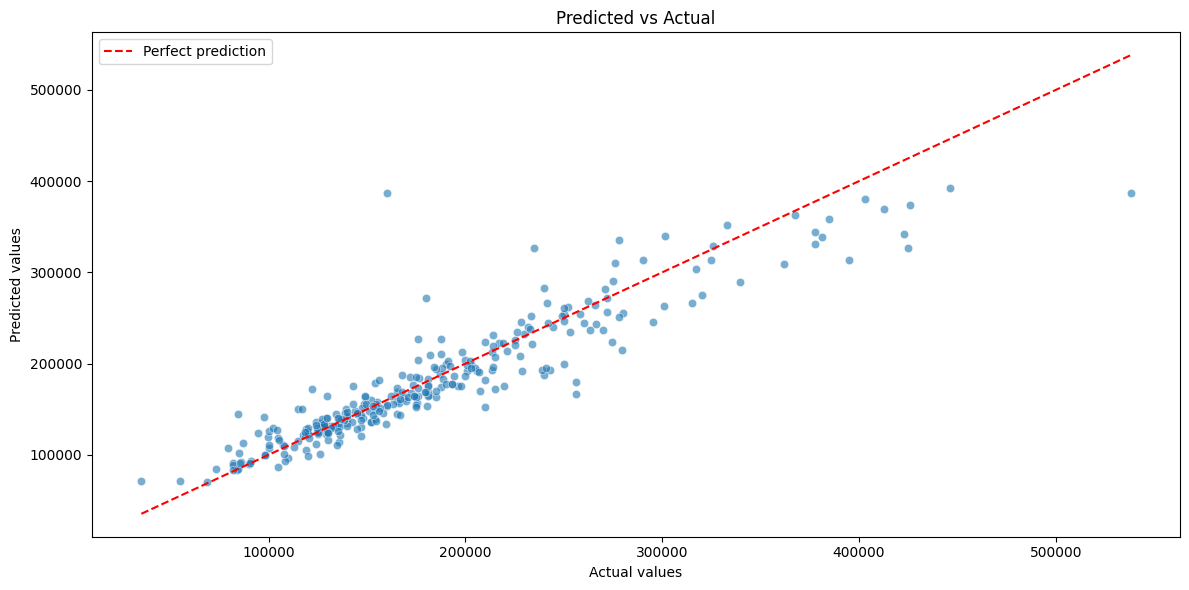

In [59]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, r2_score

final_random_forest_model = TransformedTargetRegressor(
    regressor=model_pipeline, 
    func=np.log1p,        # the function to apply to "Sale price" before training
    inverse_func=np.expm1 # the function to apply to predictions (reverse it)
)

final_random_forest_model.fit(X_train, y_train) 

y_pred = final_random_forest_model.predict(X_val)

print("MAE:", mean_absolute_error(y_val, y_pred))
print("R^2:", r2_score(y_val, y_pred))

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.6)
sns.lineplot(
    x=y_val, y=y_val,
    color="red", linestyle="--", label="Perfect prediction"
)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Predicted vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor()

gb_model_pipeline = Pipeline([
    ('data processing', data_process_pipeline),
    ('regressor', gb_model)
])

MAE: 15166.374851446573
R^2: 0.9067221309171402


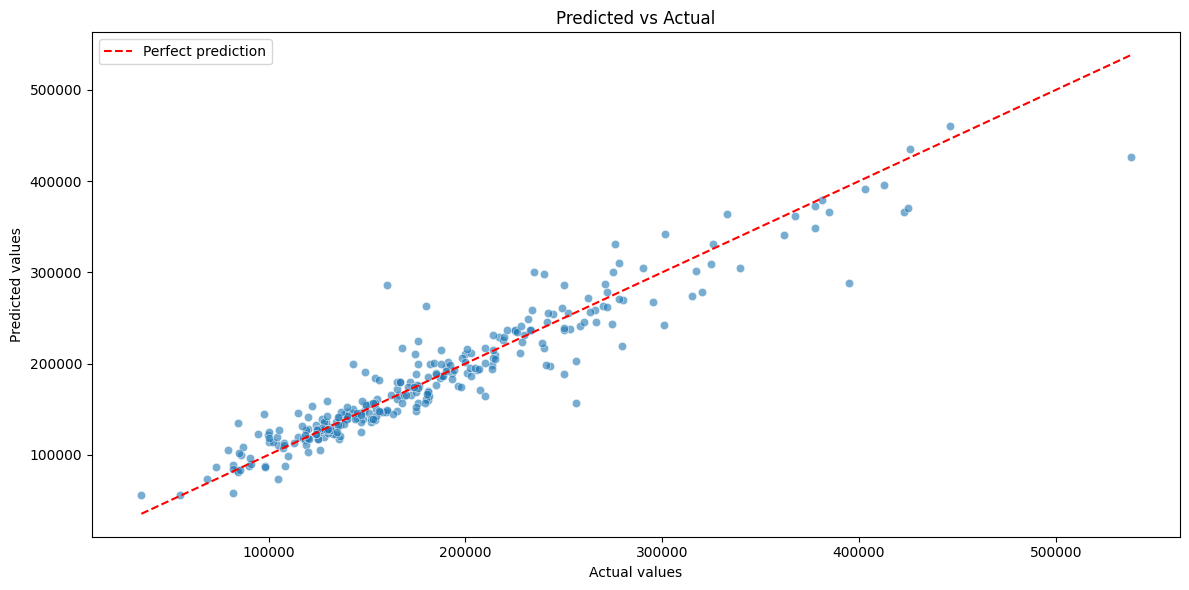

In [65]:
final_gb_model = TransformedTargetRegressor(
    regressor=gb_model_pipeline, 
    func=np.log1p,        # the function to apply to "Sale price" before training
    inverse_func=np.expm1 # the function to apply to predictions (reverse it)
)

final_gb_model.fit(X_train, y_train) 

y_pred = final_gb_model.predict(X_val)

print("MAE:", mean_absolute_error(y_val, y_pred))
print("R^2:", r2_score(y_val, y_pred))

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.6)
sns.lineplot(
    x=y_val, y=y_val,
    color="red", linestyle="--", label="Perfect prediction"
)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Predicted vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
rf_submission_pred = final_gb_model.predict(test_df)

submission_df = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": rf_submission_pred,
})

submission_path = "submission.csv"
submission_df.to_csv(submission_path, index=False)
print(f"Saved submission file to {submission_path}")
print("Size", submission_df.shape)
submission_df.head()

Saved submission file to random_forest_submission.csv
Size (1459, 2)


,Id,SalePrice
0,1461,122414.420993
1,1462,150541.206151
2,1463,183363.529469
3,1464,183502.647121
4,1465,190768.552772
